# Clustering for In-Image Content: A Concise Overview

Real-world images consist of objects, parts and textures that we’d like to discover without exhaustive labeling. 
Clustering groups similar pixels or patch-features to discover meaningful image regions (objects, parts, textures) without labels, enabling downstream tasks such as segmentation, tracking and retrieval.  In practice, clustering image pixels (by color, intensity, or learned features) often yields coherent regions because real-world scenes have contiguous, similar-appearance areas.  This makes clustering effective for region discovery, unsupervised segmentation, and object-part grouping: pixels or patches with similar appearance/function tend to fall into the same cluster, revealing objects or textured regions without supervision.
In comparison to typical clustering applications, clustering in-image content has to rely on a few key principles to make the results more coherent:

- Spatial Connectivity: 
    Clusters must form contiguous regions. Methods often embed pixel coordinates alongside color or feature vectors (e.g. Lab + XY in SLIC) or build graphs that penalize long-range joins.

- Feature Selection:
    From raw RGB/intensity (classic superpixels) to deep embeddings (DINO, CLIP): richer features yield more semantic clusters.

- Granularity Control:
    Oversegmentation (many small “superpixels”) versus directly finding whole-object clusters. Hierarchical or multi-scale approaches let you dial in the desired region size.

![placeholder](/Users/constantinseibold/workspace/CVPR_Tutorial/Identifying_Structure_In_Data/clustering/image_clustering/illustrations/deepclustering/taxonomy.png)




What You’ll Learn:

- Classical Clustering: K-means, spectral and hierarchical methods (and superpixels) for pixel grouping.

- Deep-Feature Clustering: Extract and cluster DINO/CLIP features for unsupervised object discovery.

- Foundation Model Integration: Combine clustering with CLIP for zero-shot labeling and with SAM for mask-based proposals.

- Hands-On Applications: Interactive segmentation, open-world grouping and weakly-supervised labeling using clustering pipelines.

By the end of this notebook, you’ll be equipped to select, implement and combine clustering strategies—from classic superpixels to state-of-the-art self-supervised feature clustering—for your own computer-vision tasks.



# Classical Clustering of Images: A quick overview

In this section, we turn our attention to **clustering-based** approaches—one of the most intuitive and widely used families of superpixel and segmentation algorithms. Unlike graph-cut or energy-based methods, clustering methods (e.g., [SLIC](https://www.epfl.ch/labs/ivrl/research/slic-superpixels/), [LSC](https://openaccess.thecvf.com/content_cvpr_2015/papers/Li_Superpixel_Segmentation_Using_2015_CVPR_paper.pdf), [FLIC](https://cdn.aaai.org/ojs/12286/12286-13-15814-1-2-20201228.pdf)) directly partition pixels (or pixel features) into *K* groups by iteratively assigning each pixel to the nearest cluster center in a combined feature–spatial space. This framework offers:

* Explicit Control over the number of segments (*K*) and their **compactness** (via a spatial weighting parameter).
* Linear Runtime in the number of pixels with fast convergence—ideal for real-time or large images.
* Extensibility: beyond simple Lab+XY clustering, one can plug in depth channels ([DASP](https://ieeexplore.ieee.org/document/6460572)), high-dimensional embeddings ([deep-feature clustering](https://openaccess.thecvf.com/content_ECCV_2018/papers/Varun_Jampani_Superpixel_Sampling_Networks_ECCV_2018_paper.pdf)), or adaptive seeding strategies ([preSLIC](https://www.tu-chemnitz.de/etit/proaut/publications/cws_pSLIC_ICPR.pdf)).

Below is a high-level comparison of major superpixel categories, highlighting where clustering methods sit in the broader landscape (adapted from Stutz *et al.*, 2018 ):

| Category             | Core Idea                                          | Count Control | Compactness Control | Connectivity |
| -------------------- | -------------------------------------------------- | ------------- | ------------------- | ------------ |
| Watershed-based      | Flooding from markers on gradient                  | via markers   | some variants       | ✔            |
| Density-based        | Mode-seeking in a density map                      | –             | –                   | ✖            |
| Graph-based          | Partition pixel graph by edge weights              | limited       | –                   | optional     |
| Energy-optimization  | Iteratively swap pixels to optimize an energy      | ✔             | ✔                   | ✔            |
| **Clustering-based** | **K-means style in color/feature + spatial space** | ✔             | ✔                   | post-process |

In the following notebooks cells, we will:

1. **Implement** classical clustering algorithms on images—starting with K-means in Lab+XY space (the foundation of SLIC).
2. **Enforce Connectivity**—show how a simple post-processing step converts disjoint clusters into contiguous superpixels.
3. **Explore Variants**—experiment with extensions like LSC, DASP, and preSLIC, integrating additional data modalities.
4. **Visualize & Compare**—plot segmentation boundaries and quantitatively evaluate compactness and boundary adherence.

By the end of this section, you’ll have hands-on experience setting up and tuning clustering-based superpixel methods—and understand how they serve as building blocks for advanced segmentation pipelines.



## Clustering in-Image Content: A SLIC (Simple Linear Iterative Clustering) Example

SLIC clusters pixels in the 5D Labxy space using a local k-means-like procedure.  It initializes cluster centers on a regular grid and iteratively assigns pixels to the nearest center (measured by a distance combining color and spatial proximity) and updates cluster centroids. The compactness parameter \$m\$ trades off color vs. spatial distance, so smaller \$m\$ yields boundary-adherent segments, larger \$m\$ yields more regular shapes. SLIC is extremely fast (linear complexity) and easy to use; it outperforms prior methods on segmentation benchmarks. A drawback is that SLIC tends to produce uniform, grid-like superpixels unless \$m\$ is tuned; also, it can create “orphan” pixels which require a small post-processing pass.

## Helper Functions

We define a few helper functions that let us perform some pre- and post-processing of clusterings of in-image content.
 
1. `enforce_connectivity`

- **Purpose**: This function merges connected components (small regions) within an image labeled array that are smaller than a specified size (`min_size`) into their most frequent neighboring label.
- **Inputs**:
  - `labels`: A NumPy array representing the labeled image where each unique number represents a different segment or component.
  - `min_size` (optional): The minimum size of connected components to retain as distinct; default is set to 20 pixels.
- **Process**:
  - Iterates over each label in the image.
  - Uses connected component labeling to identify all components associated with that label.
  - Checks if any component within the label's group is smaller than `min_size`.
  - If a small component is found, it merges this component into its most frequent neighboring label by scanning the immediate surroundings of each pixel belonging to the small component.
- **Output**: A modified NumPy array where small connected components are merged with their neighboring labels.

2. `get_pixel_coordinates`

- **Purpose**: Generates coordinate features for an image of height \( H \) and width \( W \).
- **Inputs**:
  - `H`: The height of the image.
  - `W`: The width of the image.
- **Process**:
  - Creates a grid of x and y coordinates using NumPy's `meshgrid`.
  - Stacks these coordinates into an array with shape \( (H \times W, 2) \), where each entry represents the coordinates of a pixel in the original image.
- **Output**: A NumPy array containing all pixel coordinates for the given dimensions.

3. `mark_boundaries`

- **Purpose**: Marks boundaries between different segments within an image to visually delineate them.
- **Inputs**:
  - `image`: The input image onto which boundaries are to be marked.
  - `segments`: An array of segment labels corresponding to each pixel in the input image.
- **Process**:
  - Utilizes `mark_boundaries` from the `skimage.segmentation` module, a utility function that overlays boundary lines on the segments within the image.
- **Output**: A new image with boundaries marked between different segments for visual inspection or analysis.


In [31]:
from skimage import color
import numpy as np
from collections import Counter
from scipy.ndimage import label as cc_label
from skimage.util import img_as_float
import cv2
from PIL import Image
from matplotlib import pyplot as plt

def enforce_connectivity(labels: np.ndarray, min_size: int = 20) -> np.ndarray:
    """
    Merge any connected component smaller than min_size into the most
    frequent neighboring label.
    """
    H, W = labels.shape
    new = labels.copy()
    for lab in np.unique(labels):
        mask = (labels == lab)
        comp, n_comp = cc_label(mask, structure=np.ones((3,3),int))
        if n_comp <= 1:
            continue
        counts = Counter(comp.flat)
        counts.pop(0, None)
        main_cc = max(counts, key=counts.get)
        for cc_id, sz in counts.items():
            if cc_id == main_cc or sz > min_size:
                continue
            ys, xs = np.where(comp == cc_id)
            for y, x in zip(ys, xs):
                y0, y1 = max(0, y-1), min(H-1, y+1)
                x0, x1 = max(0, x-1), min(W-1, x+1)
                neigh = new[y0:y1+1, x0:x1+1].flat
                choices = [int(v) for v in neigh if v != lab]
                if choices:
                    new[y, x] = Counter(choices).most_common(1)[0][0]
    return new

def get_pixel_coordinates(H, W):
    """Generate coordinate features for an H×W image."""
    x = np.arange(W)
    y = np.arange(H)
    xx, yy = np.meshgrid(x, y)
    return np.stack([yy, xx], axis=-1).reshape(-1, 2)  # (H*W, 2)

def mark_boundaries(image, segments):
    from skimage.segmentation import mark_boundaries
    return mark_boundaries(image, segments)


SLIC is one of the most common method for generating superpixels by clustering pixels based on color and spatial proximity. 

## Basic Principle
SLIC performs clustering in the combined 5-dimensional space of color (CIELAB color space) + spatial coordinates:
- **Color Information**: Captured using the CIELAB color space, which provides better perceptual uniformity compared to RGB
- **Spatial Information**: Considered through pixel coordinates

The algorithm aims to partition the image into superpixels that are:

1. **Regionally consistent** - Similar in color and spatial proximity
2. **Regularly shaped** - Approximately elliptical or circular in shape
3. **Efficient to compute**

## Mathematical Formulation

The SLIC algorithm uses a distance measure that combines both color and spatial information. For two pixels p and q:

\[
d(p, q) = \sqrt{ (\Delta L)^2 + (\Delta A)^2 + (\Delta B)^2 } \times w_c + \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} \times w_s
\]

Where:
- \(L, A, B\) are the CIELAB color components
- \(w_c = m\) is the weight for color proximity
- \(w_s = 1/m^2\) automatically adjusts based on the desired superpixel size
- \(m\) is a balancing factor (typically between 10-40)

This distance function clusters pixels that are similar in color and close spatially while maintaining regular superpixel shapes.

## Clustering Process

The algorithm consists of these main steps:

1. **Initialization**: 
   - Begin by sampling cluster centers at regular intervals in the image
   - The interval S is determined by the desired number of superpixels
   - Initialize each cluster with its corresponding pixel values and spatial coordinates

2. **Iteration**:
   - For each cluster center, consider a window of radius 2S around it
   - Assign pixels to clusters based on the minimum distance measure \(d(p, q)\)
   - Update cluster centers as the mean of all pixels in the cluster

3. **Convergence**:
   - Recompute cluster centers iteratively until they converge (stop moving significantly)
   - This typically requires 5-10 iterations for good results

4. **Optional Post-processing**:
   - A contour sharpening step can be applied to make superpixels more adhere to image boundaries

In [131]:
import numpy as np
import cv2
from skimage import img_as_float
from skimage.color import rgb2lab
from skimage.segmentation import slic, mark_boundaries
from scipy.ndimage import label as cc_label
import matplotlib.pyplot as plt

def slic_reimpl(img, coords, n_segments=200, compactness=20, max_iter=10, sigma=1.0, smooth=True, init=True, connectivity=True):
    h, w, C = img.shape
    N = h * w
    S = np.sqrt(N / n_segments)

    # 1) smoothed LAB features
    if smooth:
        # 1. Smooth (Gaussian)
        img_smooth = cv2.GaussianBlur(img, ksize=(0,0), sigmaX=sigma, sigmaY=sigma)
        lab = rgb2lab(img_smooth)
    else:
        # lab = rgb2lab(img)
        lab = img
                
    feats = lab.reshape(-1, C)
    coords_f = coords.reshape(-1, 2)

    if init:
        # 2. Init centers with gradient of smoothed L
        Lc = lab[:,:,0]
        grad_x = cv2.Sobel(Lc, cv2.CV_64F,1,0,ksize=3)
        grad_y = cv2.Sobel(Lc, cv2.CV_64F,0,1,ksize=3)
        grad = np.hypot(grad_x, grad_y)

        centers = []
        step = int(S)
        for y in range(step//2, h, step):
            for x in range(step//2, w, step):
                y0, x0 = max(y-1, 0), max(x-1, 0)
                y1, x1 = min(y+2, h), min(x+2, w)
                patch = grad[y0:y1, x0:x1]
                idx_min = np.argmin(patch)
                dy, dx = divmod(idx_min, patch.shape[1])
                cy, cx = y0+dy, x0+dx
                feat = feats[cy*w + cx]
                centers.append(np.concatenate([feat, [cy, cx]]))
        centers = np.array(centers)
    else:
        num_centers = int(len(coords) // (S**2))
        center_idxs = np.random.choice(len(coords), size=num_centers, replace=False)
        centers = np.concatenate((feats[center_idxs], coords[center_idxs]), axis=1)


    # 3) iterative 5-D k-means within 2S×2S windows
    labels = -np.ones(N, int)
    dist   = np.full(N, np.inf)
    for _ in range(max_iter):
        dist[:] = np.inf
        for i, cen in enumerate(centers):
            fc = cen[:-2]
            yc, xc = cen[-2], cen[-1]
            dy = coords_f[:,0]-yc
            dx = coords_f[:,1]-xc
            mask = (np.abs(dy)<=2*S)&(np.abs(dx)<=2*S)
            idxs = np.nonzero(mask)[0]
            dc2 = np.sum((feats[idxs]-fc)**2,axis=1)
            ds2 = dy[mask]**2 + dx[mask]**2
            D = np.sqrt(dc2 + (compactness/S)**2 * ds2)
            better = D < dist[idxs]
            dist[idxs[better]]  = D[better]
            labels[idxs[better]] = i

        # update centers
        new = []
        for i in range(len(centers)):
            pix = labels==i
            if not pix.any():
                new.append(centers[i])
            else:
                fm = feats[pix].mean(axis=0)
                ym,xm = coords_f[pix].mean(axis=0)
                new.append(np.concatenate([fm,[ym,xm]]))
        centers = np.array(new)

    labels = labels.reshape(h,w)

    if connectivity:
        # 4) connectivity enforcement: any small CCs get reassigned to the
        #    most frequent neighbor label
        min_size = int(S*S/4)
        out = np.full_like(labels, -1)
        current = 0
        for seg in range(len(centers)):
            mask = (labels==seg)
            if not mask.any(): continue
            cc, ncc = cc_label(mask, structure=np.ones((3,3)))
            for comp in range(1, ncc+1):
                comp_mask = (cc==comp)
                size = comp_mask.sum()
                if size < min_size:
                    # reassign each pixel to majority neighbor
                    yy, xx = np.nonzero(comp_mask)
                    for y,x in zip(yy,xx):
                        neigh = labels[max(y-1,0):y+2, max(x-1,0):x+2].ravel()
                        neigh = neigh[neigh!=seg]
                        if neigh.size:
                            labels[y,x] = np.bincount(neigh.astype(int)).argmax()
                else:
                    out[comp_mask] = current
                    current += 1
    else:
        out = labels
    # fill any unlabeled (rare)
    out[out<0] = 0
    return out


In [137]:
## Prepare Image:
img = cv2.imread('sample_image/bbt.jpg')  # H×W×3, values in [0,255]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,256))
h, w, _ = img.shape

# Prepare features: just RGB normalized
pixels = img.reshape(-1, 3) / 255.0  # (H*W, 3)
print(img.shape)

(256, 512, 3)


In [168]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import mark_boundaries
from skimage import img_as_float
from skimage.data import astronaut

# Segmentation settings
segment_counts = [50, 100, 200, 300, 400]
compactness = 10  

# Prepare coordinate features
coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)  # (H*W, 2)

# Container for results
results = {
    "KMeans Color Only": [],
    "KMeans Color+XY": [],
    "KMeans Seperate Distances": [],
    "KMeans SD+GridInit": [],
    "KMeans SD+GridInit+Blur": [],
    "SLIC Re-implementation": [],
    "SLIC": [],
    
}

for n_segments in segment_counts:
    # 1. KMeans on color
    km_color = KMeans(n_clusters=n_segments, random_state=0).fit(pixels)
    seg_color = km_color.labels_.reshape(h, w)
    results["KMeans Color Only"].append(mark_boundaries(img, seg_color))

    # 2. KMeans on color + normalized XY
    coord_norm = coords / np.array([h, w])
    features_xy = np.concatenate([pixels, coord_norm], axis=1)
    km_xy = KMeans(n_clusters=n_segments, random_state=0).fit(features_xy)
    seg_xy = km_xy.labels_.reshape(h, w)
    results["KMeans Color+XY"].append(mark_boundaries(img, seg_xy))

    # 3. KMeans SD (no init, no blur, no connectivity)
    seg_sd = slic_reimpl(img, coords,
                         n_segments=n_segments,
                         compactness=compactness,
                         smooth=False,
                         init=False,
                         connectivity=False)
    results["KMeans Seperate Distances"].append(mark_boundaries(img, seg_sd))

    # 4. KMeans SD + Grid Init (no blur)
    seg_sd_gi = slic_reimpl(img, coords,
                            n_segments=n_segments,
                            compactness=compactness,
                            smooth=False,
                            init=True,
                            connectivity=False)
    results["KMeans SD+GridInit"].append(mark_boundaries(img, seg_sd_gi))

    # 5. KMeans SD + Grid Init + Blur
    seg_sd_gi_blur = slic_reimpl(img, coords,
                                 n_segments=n_segments,
                                 compactness=compactness,
                                 smooth=True,
                                 sigma=1.0,
                                 init=True,
                                 connectivity=False)
    results["KMeans SD+GridInit+Blur"].append(mark_boundaries(img, seg_sd_gi_blur))

    # 6. KMeans SD + Grid Init + Blur + Connectivity
    print(img.shape)
    seg_sd_gi_blur = slic_reimpl(img, coords,
                                 n_segments=n_segments,
                                 compactness=compactness,
                                 smooth=True,
                                 sigma=1.0,
                                 init=True,
                                 connectivity=True)
    results["SLIC Re-implementation"].append(mark_boundaries(img, seg_sd_gi_blur))



    # 3. SLIC-like: weight spatial by m/S
    img_float = img_as_float(img)
    segments_slic = slic(img_float, n_segments=n_segments, compactness=compactness)
    results["SLIC"].append(mark_boundaries(img, segments_slic))

# Plotting

methods = list(results.keys())
n_methods = len(methods)
n_cols = len(segment_counts)

fig, axes = plt.subplots(n_methods + 1, n_cols, figsize=(20, 12))

# Ensure axes is 2D
axes = np.atleast_2d(axes)

# Plot results
for row, (method, images) in enumerate(results.items()):
    for col, img_out in enumerate(images):
        ax = axes[row, col]
        ax.imshow(img_out)
        ax.axis('off')
        ax.set_title(f"Segments: {segment_counts[col]}", fontsize=10)

# Plot original image row
for col in range(n_cols):
    ax = axes[-1, col]
    ax.imshow(img_float)
    ax.axis('off')
    ax.set_title("Original", fontsize=10)

# Add row labels on the left side using fig.text
row_labels = methods + ["Original"]
for row, label in enumerate(row_labels):
    fig.text(0.05,               # X position (further left than subplot area)
             1 - (row + 0.5) / (n_methods + 1),  # Y position centered on row
             label,
             va='center', ha='right',
             fontsize=14, rotation=45, weight='bold')

plt.tight_layout(rect=[0.1, 0, 1, 1])  # Leave space on the left for labels
plt.show()

ValueError: cannot reshape array of size 131072 into shape (480,480)

Currently, our SLIC implementation just covers a combination of colorspace and cooridinates. When SLIC incorporates multiple feature spaces rather than relying solely on Lab color information, it gains the ability to leverage complementary information from various sources. For example:

- Color Spaces: Combining RGB, HSV, and Lab color spaces allows the algorithm to capture different aspects of color perception and luminance.

- Texture Features: Adding texture features like Gabor filters or LBP (Local Binary Patterns) helps in better capturing structural patterns in the image.

- Semantic Features: Incorporating depth information or even learned features can help create more contextually aware superpixels.

This multi-feature approach makes SLIC more versatile and capable of handling various imaging scenarios, though it increases computational complexity slightly due to higher-dimensional feature spaces

In [200]:
import numpy as np
import cv2
from skimage.color import rgb2lab, rgb2hsv
from scipy.ndimage import label as cc_label

def slic_multi_space(feature_spaces, coords, n_segments=200, compactness=20, max_iter=10, sigma=1.0, 
                     smooth=True, init=True, connectivity=True):
    """
    SLIC that handles multiple feature spaces of varying dimensionality.
    
    Parameters:
    - feature_spaces: list of H×W×Ci numpy arrays (e.g., RGB, Lab, HSV, etc.)
    - coords: H×W×2 array of (y, x) coordinates
    - n_segments: desired number of superpixels
    - compactness: m parameter
    - max_iter: iterations for k-means
    - sigma: Gaussian smoothing sigma applied to each feature space
    
    Returns:
    - labels: H×W integer label map
    """
    H, W, _ = feature_spaces[0].shape
    N = H * W
    S = np.sqrt(N / n_segments)

    # 1. Smooth each feature space and flatten features
    feats_list = []
    for feat in feature_spaces:
        if smooth:
            # apply Gaussian blur per channel
            blurred = np.stack([cv2.GaussianBlur(feat[..., c], (0,0), sigmaX=sigma) 
                                for c in range(feat.shape[2])], axis=-1)
            feats_list.append(blurred.reshape(-1, feat.shape[2]))
        else:
            feats_list.append(feat.reshape(-1, feat.shape[2]))
    
    coords_flat = coords.reshape(-1, 2)

    if init:
        # 2. Compute gradient on first space first channel for init
        first_chan = feats_list[0][:, 0].reshape(H, W)
        gx = cv2.Sobel(first_chan, cv2.CV_64F, 1, 0, ksize=3)
        gy = cv2.Sobel(first_chan, cv2.CV_64F, 0, 1, ksize=3)
        grad = np.hypot(gx, gy)

        # 3. Initialize cluster centers on grid + lowest-gradient perturbation
        centers_feats = [ [] for _ in feats_list ]
        centers_coords = []
        step = int(S)
        for y in range(step//2, H, step):
            for x in range(step//2, W, step):
                y0, x0 = max(y-1,0), max(x-1,0)
                y1, x1 = min(y+2,H), min(x+2,W)
                patch = grad[y0:y1, x0:x1]
                idx_min = np.argmin(patch)
                dy, dx = divmod(idx_min, patch.shape[1])
                cy, cx = y0 + dy, x0 + dx
                flat_index = cy * W + cx
                for k, feats in enumerate(feats_list):
                    centers_feats[k].append(feats[flat_index])
                centers_coords.append((cy, cx))
        # Convert to arrays
        centers_feats = [np.array(cf) for cf in centers_feats]  # list of (K, Ci)
        centers_coords = np.array(centers_coords)               # (K, 2)
    else:
        pass
        # TODO
        
    # 4. K-means iterations with 5D+ distances
    labels = -np.ones(N, dtype=int)
    dist = np.full(N, np.inf)
    
    for _ in range(max_iter):
        dist[:] = np.inf
        for i in range(len(centers_coords)):
            cy, cx = centers_coords[i]
            # mask window 2S
            dy = coords_flat[:,0] - cy
            dx = coords_flat[:,1] - cx
            mask = (np.abs(dy) <= 2*S) & (np.abs(dx) <= 2*S)
            idxs = np.nonzero(mask)[0]
            # sum squared color distances across all spaces
            dc2 = np.zeros_like(idxs, dtype=float)
            for k, feats in enumerate(feats_list):
                fc = centers_feats[k][i]
                dc2 += np.sum((feats[idxs] - fc)**2, axis=1)
            ds2 = dy[mask]**2 + dx[mask]**2
            D = np.sqrt(dc2 + (compactness/S)**2 * ds2)
            better = D < dist[idxs]
            dist[idxs[better]] = D[better]
            labels[idxs[better]] = i

        # update centers
        new_feats = [np.zeros_like(cf) for cf in centers_feats]
        new_coords = np.zeros_like(centers_coords, dtype=float)
        counts = np.zeros(len(centers_coords), dtype=int)
        for i in range(len(centers_coords)):
            pix = (labels == i)
            if not pix.any():
                # retain old center
                new_feats = [nf for nf in new_feats]
                new_coords[i] = centers_coords[i]
            else:
                counts[i] = pix.sum()
                for k, feats in enumerate(feats_list):
                    new_feats[k][i] = feats[pix].mean(axis=0)
                new_coords[i] = coords_flat[pix].mean(axis=0)
        centers_feats = new_feats
        centers_coords = new_coords

    # 5. Enforce connectivity
    labels = labels.reshape(H, W)
    min_size = int(S*S/4)
    out = np.full_like(labels, -1)
    label_id = 0
    for seg_id in range(len(centers_coords)):
        mask = (labels == seg_id)
        if not mask.any():
            continue
        cc, num = cc_label(mask, structure=np.ones((3,3)))
        for comp in range(1, num+1):
            comp_mask = (cc == comp)
            size = comp_mask.sum()
            if size < min_size:
                # reassign small component
                ys, xs = np.nonzero(comp_mask)
                for y, x in zip(ys, xs):
                    neigh = labels[max(y-1,0):y+2, max(x-1,0):x+2].ravel()
                    neigh = neigh[neigh != seg_id]
                    if neigh.size:
                        labels[y, x] = np.bincount(neigh.astype(int)).argmax()
            else:
                out[comp_mask] = label_id
                label_id += 1
    out[out < 0] = 0

    return out

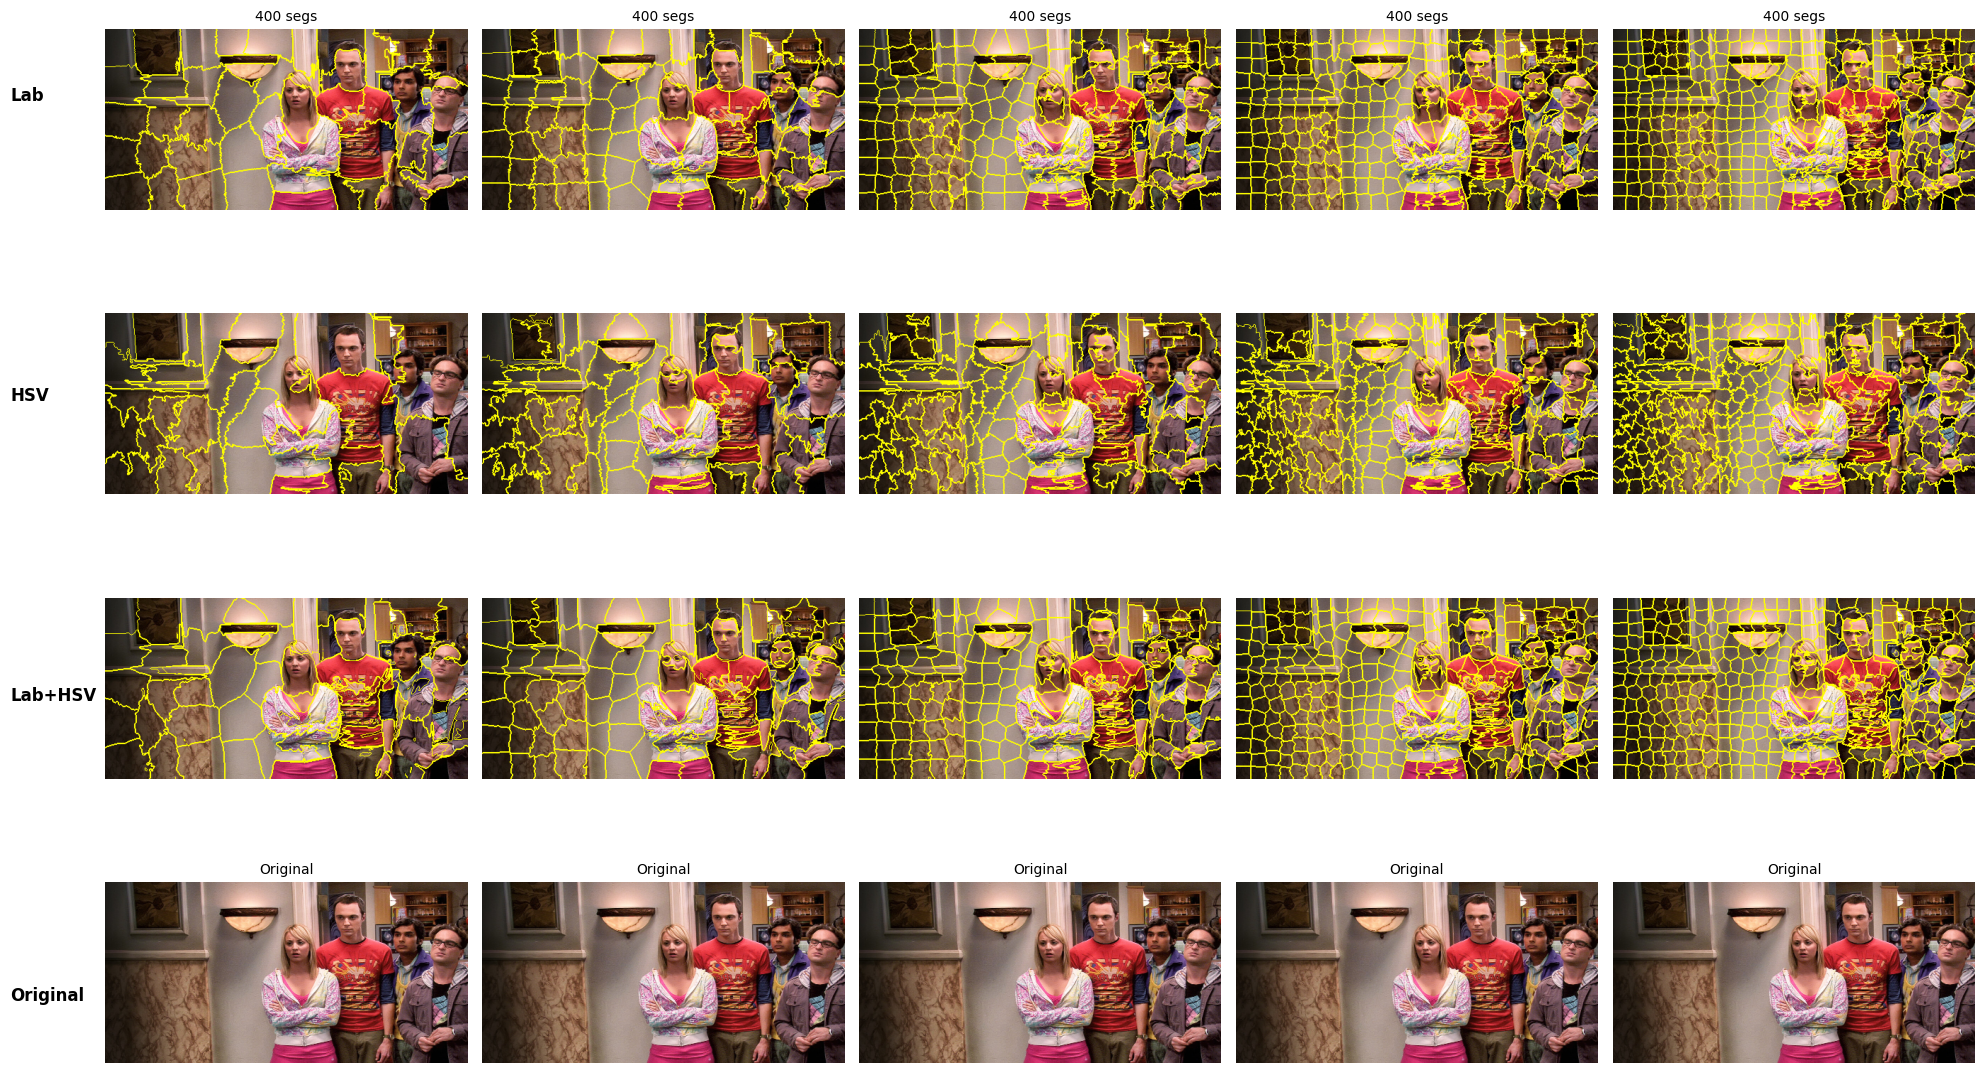

In [63]:

h, w, _ = img.shape
coords = np.indices((h, w)).transpose(1, 2, 0).reshape(h, w, 2)

# Define feature spaces
spaces = {
    'RGB': img,
    'Lab': rgb2lab(img),
    'HSV': rgb2hsv(img)
}

# Define multi-space combos
task_spaces = {
    'Lab': ['Lab'],
    'HSV': ['HSV'],
    'Lab+HSV': ['Lab', 'HSV'],
}

# parameters
segment_counts = [50, 100, 200, 300, 400]
compactness = 20

# placeholder for results
results = {name: [] for name in task_spaces.keys()}

# slic_multi_space must be defined/imported above
for n_segments in segment_counts:
    for name, keys in task_spaces.items():
        # pick feature arrays for this method
        feats = [spaces[k] for k in keys]
        if len(feats) == 1:
            # standard SLIC on that space
            seg = slic(feats[0], n_segments=n_segments, compactness=compactness, start_label=0)
        else:
            # multi-space custom implementation
            seg = slic_multi_space(feats, coords, n_segments=n_segments,
                                   compactness=compactness, max_iter=10, sigma=1.0)
        # store boundary overlay on original img
        results[name].append(mark_boundaries(img, seg))

# Plotting with original layout style
methods = list(results.keys())
n_rows = len(methods) + 1  # extra row for original image
n_cols = len(segment_counts)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = np.atleast_2d(axes)

# fill in segmentation results
for row, method in enumerate(methods):
    for col, boundary_img in enumerate(results[method]):
        ax = axes[row, col]
        ax.imshow(boundary_img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"{n_segments} segs".replace('{n_segments}', str(segment_counts[col])), fontsize=10)

# final row: original image
for col in range(n_cols):
    ax = axes[-1, col]
    ax.imshow(img)
    ax.axis('off')
    if -1 == -1:
        ax.set_title("Original", fontsize=10)

# add row labels
for idx, label in enumerate(methods + ['Original']):
    y = 1 - (idx + 0.5) / n_rows
    fig.text(0.01, y, label, va='center', ha='left', fontsize=12, weight='bold', rotation=0)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()


## Downstream Applications of Superpixels

Superpixels serve as mid-level representations that simplify many vision problems. We highlight several applications:

* **Interactive Segmentation:** Users mark foreground/background scribbles, and algorithms propagate labels. By working on a superpixel graph (pixels grouped), one can dramatically speed up graph-cut or random-walker segmentation while respecting boundaries. For example, one can label superpixels touched by a foreground mark and then assign each superpixel a label by graph optimization.

* **Zero-Shot/Open-Set Segmentation:** Superpixels can also facilitate “open-vocabulary” or zero-shot segmentation (e.g. with CLIP). A strategy is to embed each superpixel region (e.g. via a vision-language model) and assign the most likely semantic label without per-pixel training. Pseudocode would be:

This approach leverages superpixels to reduce computation (one embedding per region) and to impose spatial consistency. Recent works combine superpixels with diffusion or graph models for label propagation without retraining.


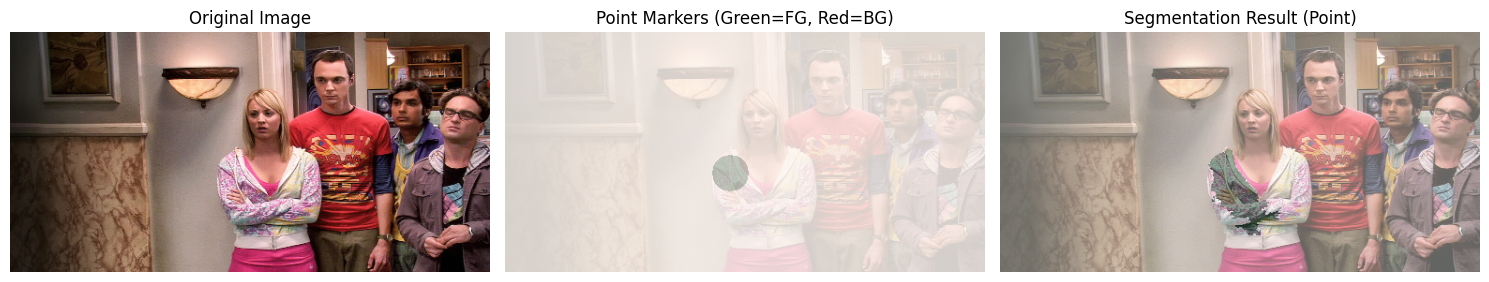

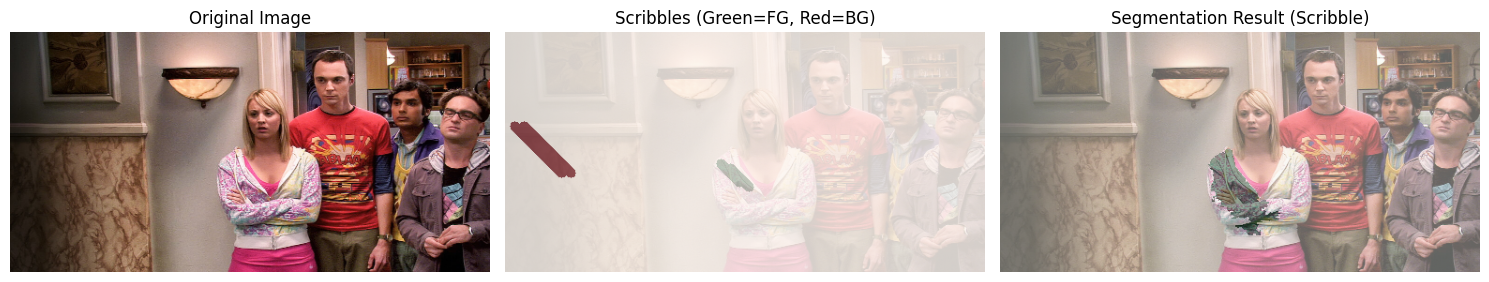

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, color, draw

# Load sample image
image = img_as_float(img)

# Compute superpixels
segments = segmentation.slic(image, n_segments=200, compactness=10, start_label=1)

# Utility to create a small mask around a point
def create_point_mask(shape, point, radius=5):
    rr, cc = draw.disk(point, radius, shape=shape)
    mask = np.zeros(shape[:2], dtype=bool)
    mask[rr, cc] = True
    return mask

# For visualization: enlarge mask by dilation
from skimage.morphology import dilation, disk

# --- Example 1: Point-based interactive segmentation ---
fg_point = (150, 240)
bg_point = (300, 50)
fg_mask_point = create_point_mask(image.shape, fg_point, radius=5)
bg_mask_point = create_point_mask(image.shape, bg_point, radius=5)

# Label superpixels
labels_point = np.zeros_like(segments)
for seg_id in np.unique(segments):
    seg_mask = (segments == seg_id)
    if np.any(seg_mask & fg_mask_point):
        labels_point[seg_mask] = 1  # Foreground
    elif np.any(seg_mask & bg_mask_point):
        labels_point[seg_mask] = 2  # Background

segmented_point = (labels_point == 1)

# Visualization for point-based
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# overlay markers enlarged
vis_fg = dilation(fg_mask_point, disk(15))
vis_bg = dilation(bg_mask_point, disk(15))
axes[1].imshow(image)
axes[1].imshow(vis_fg, cmap='Greens', alpha=0.6)
axes[1].imshow(vis_bg, cmap='Reds', alpha=0.6)
axes[1].set_title("Point Markers (Green=FG, Red=BG)")
axes[1].axis('off')

axes[2].imshow(image)
axes[2].imshow(segmented_point, cmap='Greens', alpha=0.4)
axes[2].set_title("Segmentation Result (Point)")
axes[2].axis('off')
plt.tight_layout()
plt.show()


# --- Example 2: Scribble-based interactive segmentation ---
# Simulate scribbles
fg_scribble = np.zeros(image.shape[:2], dtype=bool)
rr, cc = draw.line(140, 230, 160, 250)
fg_scribble[rr, cc] = True
rr, cc = draw.line(145, 240, 165, 260)
fg_scribble[rr, cc] = True

bg_scribble = np.zeros(image.shape[:2], dtype=bool)
rr, cc = draw.line(100, 10, 150, 60)
bg_scribble[rr, cc] = True
rr, cc = draw.line(100, 20, 150, 70)
bg_scribble[rr, cc] = True

# Label superpixels
labels_scribble = np.zeros_like(segments)
for seg_id in np.unique(segments):
    seg_mask = (segments == seg_id)
    if np.any(seg_mask & fg_scribble):
        labels_scribble[seg_mask] = 1
    elif np.any(seg_mask & bg_scribble):
        labels_scribble[seg_mask] = 2

segmented_scribble = (labels_scribble == 1)

# Visualize scribbles larger
vis_fg_sc = dilation(fg_scribble, disk(5))
vis_bg_sc = dilation(bg_scribble, disk(5))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(image)
axes[1].imshow(vis_fg_sc, cmap='Greens', alpha=0.6)
axes[1].imshow(vis_bg_sc, cmap='Reds', alpha=0.6)
axes[1].set_title("Scribbles (Green=FG, Red=BG)")
axes[1].axis('off')

axes[2].imshow(image)
axes[2].imshow(segmented_scribble, cmap='Greens', alpha=0.4)
axes[2].set_title("Segmentation Result (Scribble)")
axes[2].axis('off')

plt.tight_layout()
plt.show()



## Integration with Foundation Models (CLIP, SAM, etc.)

Clustering can be combined with or enhanced by large pre-trained models:

* **CLIP-based Clustering:** The CLIP model embeds image patches and text into a joint space.  One can cluster CLIP image embeddings of pixels or regions to group semantically similar areas.  Recent works indeed use CLIP for *unsupervised segmentation*: by matching CLIP features to text, they assign pixel labels in a zero-shot manner.  In principle, one could cluster CLIP patch tokens (e.g. via k-means) to get semantic regions and then label each cluster by nearest class text.  As a result, “CLIP-based unsupervised segmentation approaches” have emerged that greatly outperform traditional methods.

*Figure: CLIP/vision-language features can distinguish content. For example, clustering pixels of the peeled orange (above) in CLIP space would naturally separate the orange segments from background, enabling zero-shot labeling of “orange fruit.”*.

* **Segment Anything Model (SAM):** SAM is a promptable segmentation model trained on 1B masks.  It can produce masks for *any* object in an image (given a prompt like a box or point).  In a clustering workflow, SAM masks can serve as high-quality pre-segmentation units: one can cluster or label entire SAM-generated regions.  For example, apply SAM to get all salient masks in an image (sky, trees, buildings, etc.), then cluster or query these masks with a vision-language model.  Since SAM transfers zero-shot to new tasks, it provides a rich set of region candidates that clustering methods can refine or combine.

* **Zero-Shot Label Propagation:** More generally, after clustering image segments, one can use vision-language models (like CLIP) to assign semantic labels without training.  For instance, given cluster masks or superpixels, compute the average CLIP embedding of each and find the nearest text description.  This combines clustering with language priors for open-vocabulary segmentation.

By leveraging CLIP and SAM, clustering-based segmentation becomes more powerful.  CLIP gives clusters a semantic grounding (e.g. grouping all “dog” pixels), and SAM gives high-quality masks to cluster or label.  Together, these foundation models enable effective clustering that is both *image-aware* and *language-aware*, supporting zero-shot segmentation and multi-modal understanding.



In [110]:
# Example 1: Zero-Shot CLIP Segmentation via Feature-Map Pooling
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
from skimage import data, segmentation, color, img_as_float
import matplotlib.pyplot as plt

# 1. Load and segment image
image = img_as_float(data.astronaut())
segments = segmentation.slic(image, n_segments=200, compactness=10, start_label=0)
n_regions = segments.max() + 1

# 2. Load CLIP and prepare inputs for full-image encoding
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 3. Encode the full image to get per-patch features
#    We'll grab the last hidden state from ViT (after projection) and reshape to a 2D map.
with torch.no_grad():
    clip_inputs = processor(images=(image*255).astype(np.uint8), return_tensors="pt")
    outputs = model.vision_model(**clip_inputs.pixel_values.unsqueeze(0), output_hidden_states=True)
    # hidden_states[-1] is (1, num_patches+1, D); skip CLS token at index 0
    patch_feats = outputs.hidden_states[-1][0,1:,:]  # (num_patches, D)
    D = patch_feats.shape[-1]

# 4. Reshape to spatial map (for ViT-32: image 224×224 → 7×7 patches, adjust if you scale)
#    Here we assume processor resized to 224×224.
num_patches = int(np.sqrt(patch_feats.shape[0]))
feat_map = patch_feats.reshape(num_patches, num_patches, D).cpu().numpy()

# 5. Prepare text embeddings
labels = ["penny","sheldon","leonard","rajesh","book shelf"]
text_tok = processor(text=labels, return_tensors="pt", padding=True)
with torch.no_grad():
    text_emb = model.get_text_features(**text_tok)
    text_emb /= text_emb.norm(dim=-1, keepdim=True)
text_emb = text_emb.cpu().numpy()  # (n_labels, D)

# 6. For each superpixel, pool its patch embeddings and pick the best label
seg_labels = np.zeros(n_regions, dtype=int)
# map each pixel to its patch coordinate
H, W, _ = image.shape
patch_size = H // num_patches
for rid in range(n_regions):
    mask = (segments == rid)
    ys, xs = np.where(mask)
    pi = np.unique(xs // patch_size)
    pj = np.unique(ys // patch_size)
    # gather all patch embeddings overlapping this region
    region_feats = []
    for y in pj:
        for x in pi:
            region_feats.append(feat_map[y, x])
    region_feats = np.stack(region_feats, axis=0)
    avg_feat = region_feats.mean(axis=0)
    avg_feat /= np.linalg.norm(avg_feat)
    sims = avg_feat @ text_emb.T
    seg_labels[rid] = sims.argmax()

# 7. Visualize
overlay = color.label2rgb(seg_labels[segments], image, kind="overlay", alpha=0.6)
boundary = segmentation.mark_boundaries(image, segments)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.imshow(image);    ax1.set_title("Original")
ax2.imshow(boundary); ax2.set_title("Superpixel Boundaries")
ax3.imshow(overlay);  ax3.set_title("Zero-Shot via Feature-Pooling")
for ax in (ax1,ax2,ax3): ax.axis("off")
plt.tight_layout()
plt.show()


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

TypeError: CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (position_embedding): Embedding(50, 768)
  )
  (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (post_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
) argument after ** must be a mapping, not Tensor

In [113]:
import torch



Using cache found in /Users/constantinseibold/.cache/torch/hub/facebookresearch_dino_main


Using cache found in /Users/constantinseibold/.cache/torch/hub/facebookresearch_dino_main


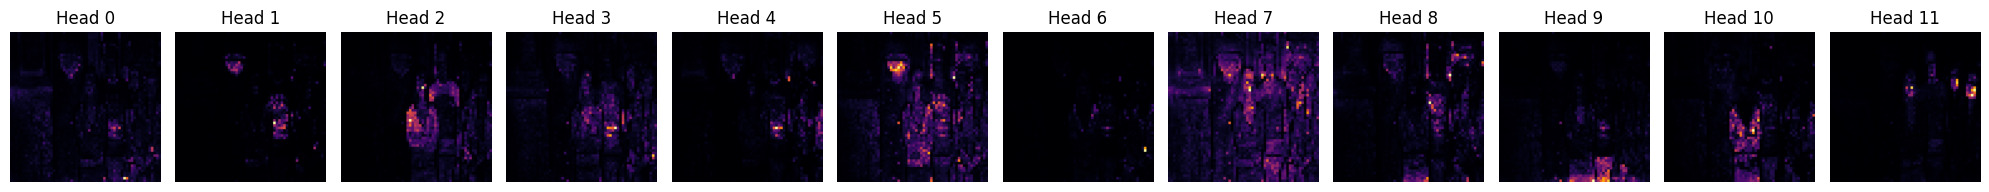

In [192]:

import torch
import torchvision.transforms as transforms
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# Load utility for optional mask visualization
from skimage.measure import find_contours
from matplotlib.patches import Polygon
import cv2
import random
import colorsys
import os

model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')

img = Image.open('sample_image/bbt.jpg').convert("RGB")


transform = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])
img_tensor = transform(img).unsqueeze(0)
coords = np.indices((480, 480)).transpose(1, 2, 0).reshape(480, 480, 2)

# make the image divisible by patch size (8 for vitb8)
patch_size = 8
_, _, h, w = img_tensor.shape
h -= h % patch_size
w -= w % patch_size
img_tensor = img_tensor[:, :, :h, :w]

# cell 4: get attention maps
with torch.no_grad():
    attentions = model.get_last_selfattention(img_tensor)

# Focus on CLS token's attention
nh = attentions.shape[1]  # number of heads
attn = attentions[0, :, 0, 1:]  # [num_heads, num_patches]
h_featmap = h // patch_size
w_featmap = w // patch_size
attn = attn.reshape(nh, h_featmap, w_featmap)

# interpolate attention to image size
attn_resized = torch.nn.functional.interpolate(
    attn.unsqueeze(0), scale_factor=patch_size, mode="nearest"
)[0]

# cell 5: visualize attention heads
fig, axs = plt.subplots(1, nh, figsize=(20, 5))
for i in range(nh):
    axs[i].imshow(attn_resized[i].cpu(), cmap='inferno')
    axs[i].axis('off')
    axs[i].set_title(f'Head {i}')
plt.tight_layout()
plt.show()






In [193]:

# cell 4: get attention maps
with torch.no_grad():
    dino_features = model.get_intermediate_layers(img_tensor, len(model.blocks))[-1]
    
feat_map = dino_features[:,1:].reshape(1,480//8,480//8,-1)
print(feat_map.shape)
feat_map_resized = torch.nn.functional.interpolate(
    feat_map.permute(0,3,1,2), scale_factor=patch_size, mode="nearest"
)[0]


torch.Size([1, 60, 60, 768])


(480, 480, 768)
(480, 480, 768)
(480, 480, 768)
(480, 480, 768)
(480, 480, 768)


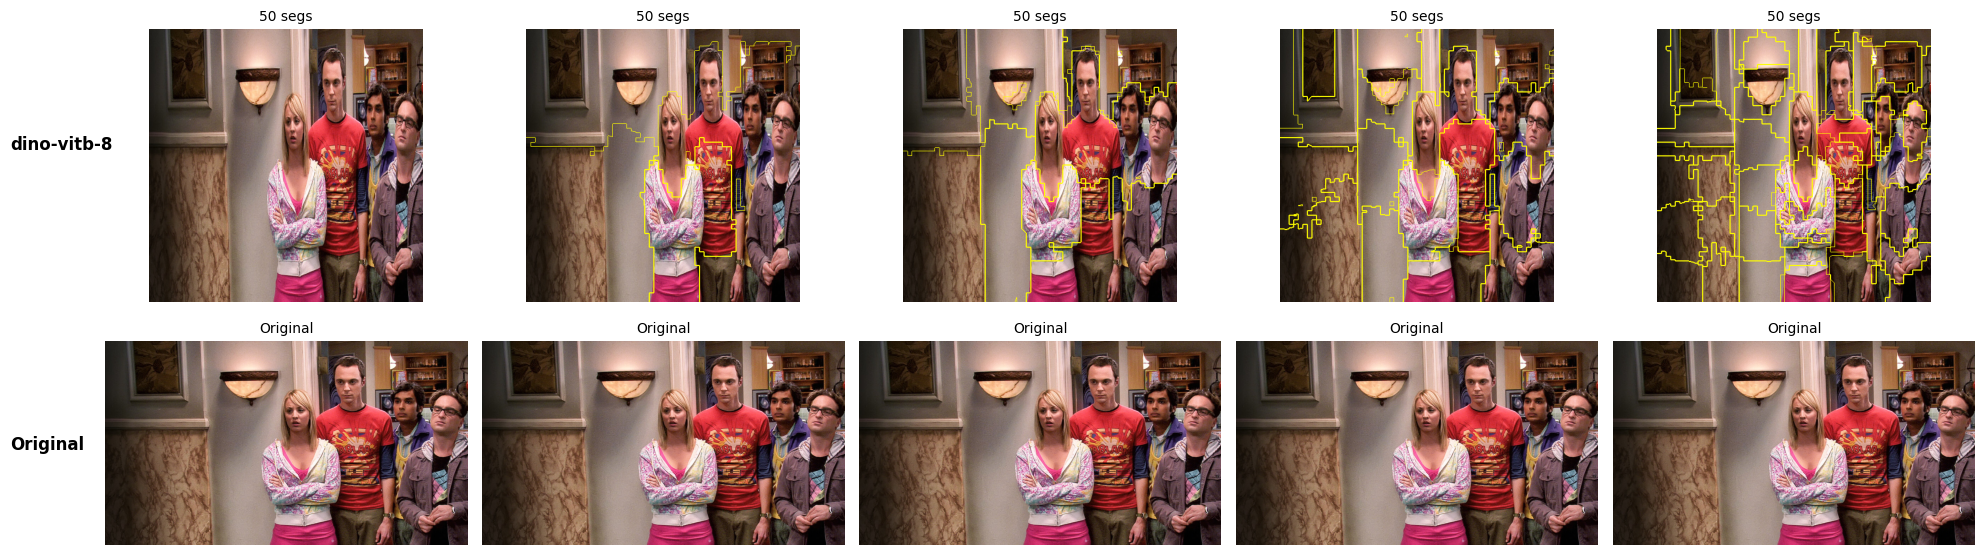

In [199]:

# parameters
segment_counts = [2,5, 10, 15, 50,]
compactness = 1

# placeholder for results
results = {name: [] for name in ['dino-vitb-8']}

# slic_multi_space must be defined/imported above
for n_segments in segment_counts:
    for name in ['dino-vitb-8']:
        cv_img = cv2.resize(np.array(img),(480,480))
        cv_img_float = img_as_float(cv_img)
        # pick feature arrays for this method
        feats = feat_map_resized.permute(1,2,0).numpy()
        feats = (feats-feats.mean(-1, keepdims=True))/(feats.max(-1, keepdims=True)-feats.min(-1, keepdims=True))
        print(feats.shape)
        seg = slic_reimpl(feats[:,:,:], coords, n_segments=n_segments,
                                compactness=compactness, max_iter=10, sigma=1.0, init=True, smooth=False)
        
        # store boundary overlay on original img
        results[name].append(mark_boundaries(cv_img, seg))

# Plotting with original layout style
methods = list(results.keys())
n_rows = len(methods) + 1  # extra row for original image
n_cols = len(segment_counts)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = np.atleast_2d(axes)

# fill in segmentation results
for row, method in enumerate(methods):
    for col, boundary_img in enumerate(results[method]):
        ax = axes[row, col]
        ax.imshow(boundary_img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"{n_segments} segs".replace('{n_segments}', str(segment_counts[col])), fontsize=10)

# final row: original image
for col in range(n_cols):
    ax = axes[-1, col]
    ax.imshow(img)
    ax.axis('off')
    if -1 == -1:
        ax.set_title("Original", fontsize=10)

# add row labels
for idx, label in enumerate(methods + ['Original']):
    y = 1 - (idx + 0.5) / n_rows
    fig.text(0.01, y, label, va='center', ha='left', fontsize=12, weight='bold', rotation=0)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

(480, 480, 768)
(480, 480, 768)
(480, 480, 768)
(480, 480, 768)
(480, 480, 768)


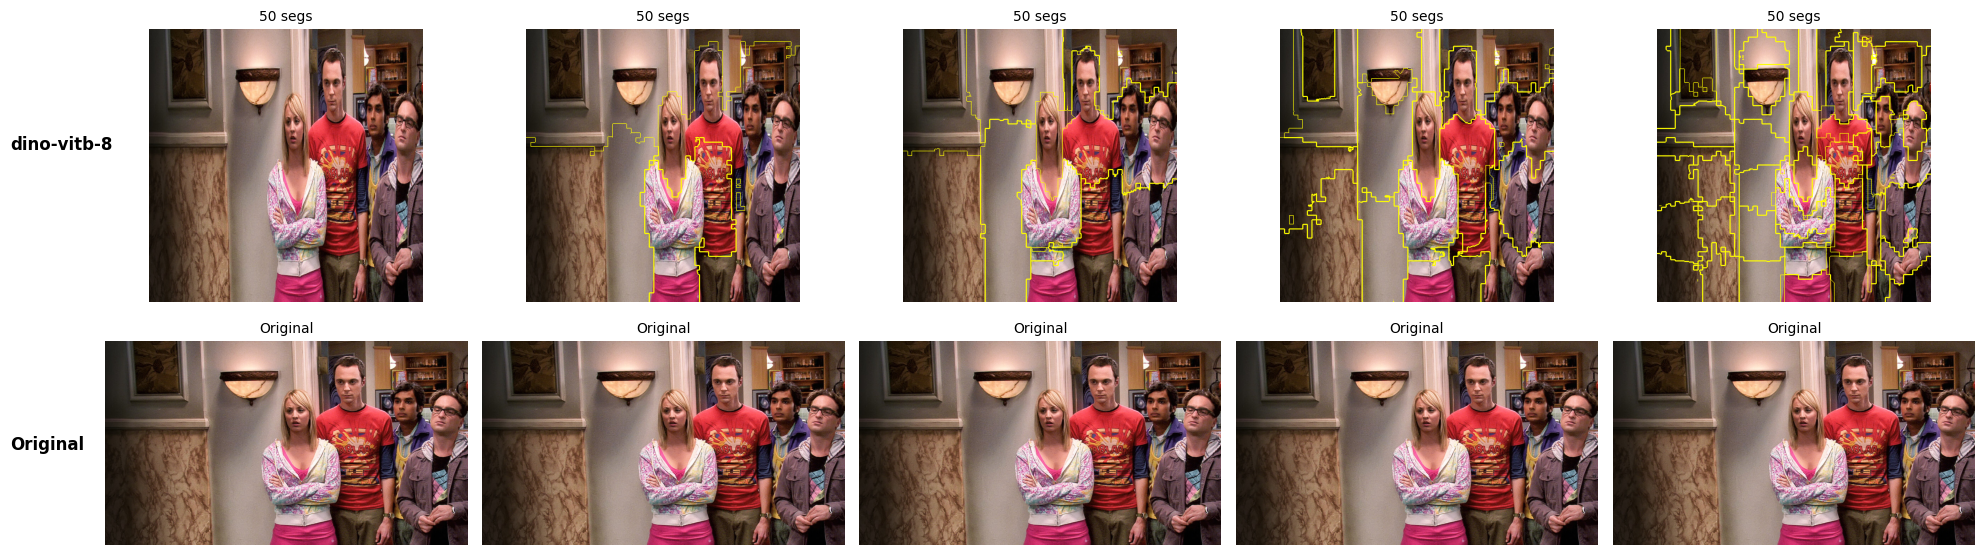

In [202]:

# parameters
segment_counts = [2,5, 10, 15, 50,]
compactness = 1

# placeholder for results
results = {name: [] for name in ['dino-vitb-8']}

# slic_multi_space must be defined/imported above
for n_segments in segment_counts:
    for name in ['dino-vitb-8']:
        # pick feature arrays for this method
        cv_img = cv2.resize(np.array(img),(480,480))
        cv_img_float = img_as_float(cv_img)
        feats = feat_map_resized.permute(1,2,0).numpy()
        feats = (feats-feats.mean(-1, keepdims=True))/(feats.max(-1, keepdims=True)-feats.min(-1, keepdims=True))
        print(feats.shape)
        seg = slic_multi_space([feats, cv_img_float], coords, n_segments=n_segments,
                                   compactness=compactness, max_iter=10, sigma=1.0, smooth=False)
        
        # store boundary overlay on original img
        results[name].append(mark_boundaries(cv_img, seg))

# Plotting with original layout style
methods = list(results.keys())
n_rows = len(methods) + 1  # extra row for original image
n_cols = len(segment_counts)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = np.atleast_2d(axes)

# fill in segmentation results
for row, method in enumerate(methods):
    for col, boundary_img in enumerate(results[method]):
        ax = axes[row, col]
        ax.imshow(boundary_img)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"{n_segments} segs".replace('{n_segments}', str(segment_counts[col])), fontsize=10)

# final row: original image
for col in range(n_cols):
    ax = axes[-1, col]
    ax.imshow(img)
    ax.axis('off')
    if -1 == -1:
        ax.set_title("Original", fontsize=10)

# add row labels
for idx, label in enumerate(methods + ['Original']):
    y = 1 - (idx + 0.5) / n_rows
    fig.text(0.01, y, label, va='center', ha='left', fontsize=12, weight='bold', rotation=0)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()


## Modern Clustering-Based Methods

Recent research has shown that clustering deep features from large models yields powerful unsupervised segmentation:

* **DINO and Vision Transformers:** In *Emerging Properties of ViTs*, Caron *et al.* showed that self-supervised ViT (DINO) features form coherent object segments without labels.  The \[CLS] attention maps automatically localize objects, implying that clustering patch tokens can reveal object masks.

* **TokenCut (Wang *et al.*, CVPR 2022):** TokenCut builds a fully-connected graph on DINO patch embeddings and solves a Normalized Cut problem to find the main object in the image.  This simple, training-free method “uses the features obtained by a self-supervised transformer to detect and segment salient objects”.  In practice it often outputs a tight bounding box or mask around the dominant object (see figure).

*Figure: Example of unsupervised object discovery by TokenCut*.

* **STEGO (Hamilton *et al.*, CVPR 2022):** STEGO distills correspondences in self-supervised features to produce unsupervised semantic segmentation.  It trains a small network on top of frozen DINO-ViT features using a contrastive loss that encourages semantically similar regions to share labels.  As the authors note, “current unsupervised feature learning frameworks already generate dense features whose correlations are semantically consistent”.  STEGO clusters these features into high-quality discrete labels, significantly improving mIoU on COCO-Stuff and Cityscapes over prior methods.

* **Mask DINO (Li *et al.*, CVPR 2023):** A supervised instance segmentation model, Mask DINO extends the DINO (DETR) framework to predict masks for all objects simultaneously.  While not unsupervised, it illustrates the power of transformer-based clustering of queries and pixels for segmentation: Mask DINO “predicts a set of binary masks” for all objects and achieves state-of-the-art results.  This hints at how clustering query embeddings with pixel features yields object masks.

These modern methods show that clustering or graph-partitioning on rich feature spaces can directly produce object-level segments.  Unlike traditional superpixels (which target color homogeneity), DINO/TokenCut/STEGO aim for semantic coherence.  In experiments, such methods achieve *unsupervised* saliency and object detection performance well above earlier baselines.

## Clustering vs. Superpixels

Both clustering and superpixel methods group pixels, but with different emphases:

* **Goals:** Superpixel algorithms (SLIC, QuickShift, Felzenszwalb) aim to oversegment the image into compact, uniformly-colored regions.  They prioritize regular shapes and local homogeneity.  In contrast, clustering (especially on deep features) often targets semantic grouping: it seeks to merge pixels belonging to the same object or semantic part, even if they are non-local or have varied appearance.

* **Outputs:** Superpixels produce many small, contiguous patches.  These are useful for reducing complexity (fewer regions than pixels) and serve as nodes for further processing (e.g. CRF refinement).  Clustering methods can produce either a few large segments or a hierarchy.  For example, K-means on pixel color may yield a handful of color regions (some not necessarily connected), whereas spectral clustering enforces connectivity through graph structure.  In practice, classical clustering (without spatial constraints) can produce clusters that are spatially disjoint, whereas superpixels guarantee locality.

* **Downstream Use:** Superpixels are often used as a preprocessing step (e.g. in classical CRFs or to speed up graph cuts).  Clustering outputs tend to be the final regions for tasks like unsupervised segmentation or grouping.  For instance, TokenCut/STEGO directly output object masks, whereas a superpixel method might simply initialize a mask that must be merged.

In summary, superpixels and clustering share the idea of grouping, but superpixels are a form of *low-level oversegmentation*, while feature clustering can aim directly at high-level image interpretation (objects, parts).  In practice, they can be complementary: one might apply superpixel clustering first, then merge those superpixels by high-level feature clustering to get semantic segments.
